<a href="https://colab.research.google.com/github/liuyssss/HW1/blob/main/%E5%9F%BA%E4%BA%8Epytorch%E5%AE%9E%E7%8E%B0GAN%E6%89%8B%E5%86%99%E4%BD%93%E6%95%B0%E5%AD%97%E7%9A%84%E7%94%9F%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable

import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



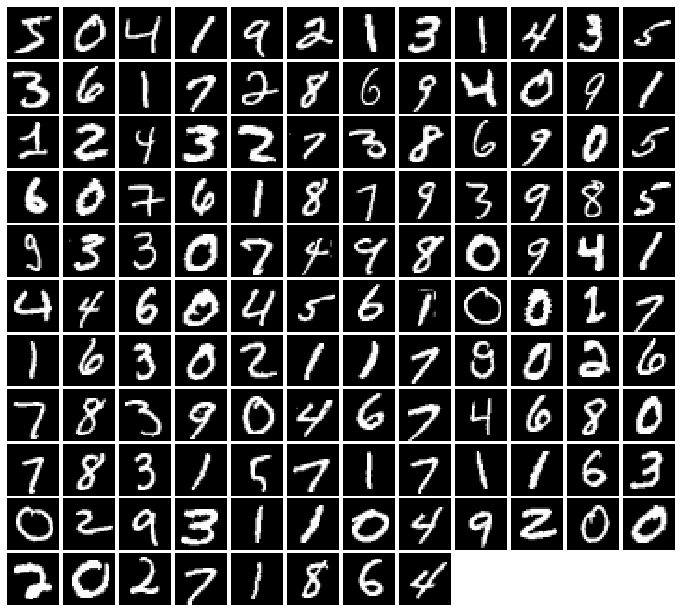

In [ ]:
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

train_set = MNIST('mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

val_set = MNIST('mnist', train=True, download=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)



In [ ]:
class build_dc_classifier(nn.Module):
    def __init__(self):
        super(build_dc_classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x



In [ ]:
class build_dc_generator(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(build_dc_generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape 通道是 128，大小是 7x7
        x = self.conv(x)
        return x



In [ ]:
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    false_labels = Variable(torch.zeros(size, 1)).float().cuda()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss

def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    loss = bce_loss(logits_fake, true_labels)
    return loss



In [ ]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer



In [ ]:
def train_dc_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.data, g_error.data))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1



Iter: 0, D: 1.377, G:1.009


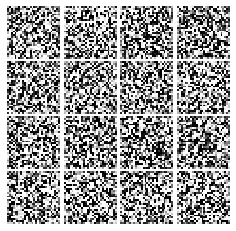


Iter: 250, D: 0.8484, G:2.496


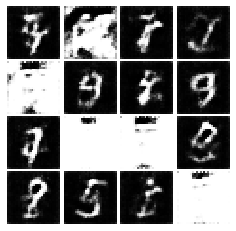


Iter: 500, D: 1.028, G:1.099


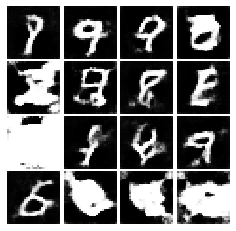


Iter: 750, D: 0.8717, G:1.695


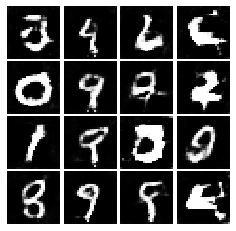


Iter: 1000, D: 1.123, G:1.138


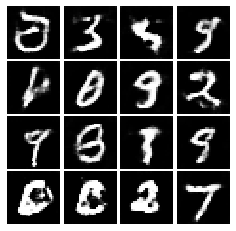


Iter: 1250, D: 0.9525, G:1.557


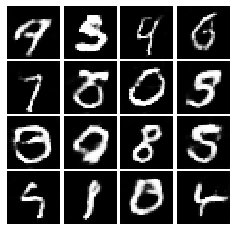


Iter: 1500, D: 1.011, G:0.8721


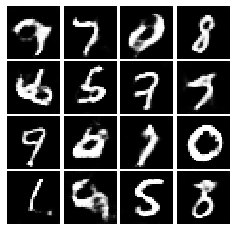


Iter: 1750, D: 1.001, G:1.293


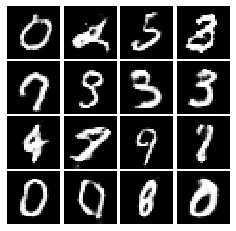


Iter: 2000, D: 1.085, G:1.981


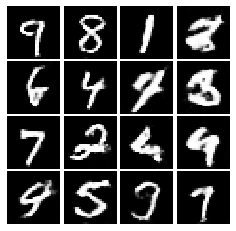


Iter: 2250, D: 1.118, G:1.433


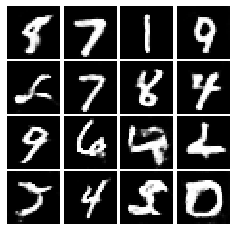


Iter: 2500, D: 1.067, G:0.8924


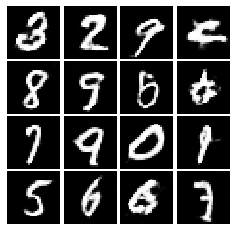


Iter: 2750, D: 1.09, G:1.135


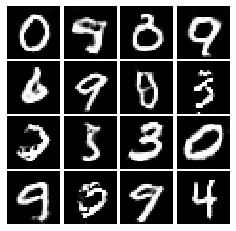


Iter: 3000, D: 1.244, G:0.8975


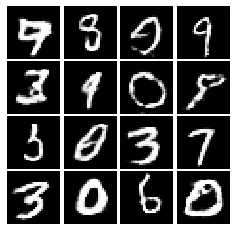


Iter: 3250, D: 0.8898, G:1.684


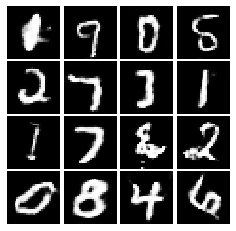


Iter: 3500, D: 1.205, G:0.7986


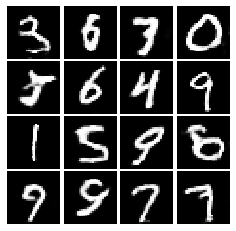


Iter: 3750, D: 1.13, G:1.002


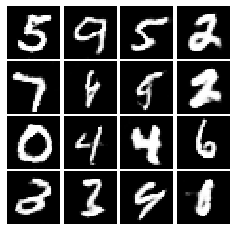

In [ ]:
D_DC = build_dc_classifier().cuda()
G_DC = build_dc_generator().cuda()

D_DC_optim = get_optimizer(D_DC)
G_DC_optim = get_optimizer(G_DC)

train_dc_gan(D_DC, G_DC, D_DC_optim, G_DC_optim, discriminator_loss, generator_loss, num_epochs=10)